#### Predicing how long will the patient stay in the hospital
* one hot encoding
* ordinal encoding

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import tensorflow as tf

In [2]:
## Adapted from https://www.kaggle.com/code/todorraichev/024-hospital-stays
data = pd.read_csv("/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data.csv")

In [3]:
data

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


In [4]:
data.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [5]:
def impute_missing_values(data, columns):
    for column in columns:
        data[column] = data[column].fillna(data[column].mean())

columns_with_na = ['Bed Grade', 'City_Code_Patient']

impute_missing_values(data, columns_with_na)

In [6]:
data.isnull().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

#### Encoding

In [7]:
data.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [8]:
def get_categorical_uniques(data):
    categorical_columns = [column for column in data.dtypes.index if data.dtypes[column] == 'object']
    categorical_uniques = { column : data[column].unique() for column in categorical_columns}
    return categorical_uniques

get_categorical_uniques(data)

{'Hospital_type_code': array(['c', 'e', 'b', 'a', 'f', 'd', 'g'], dtype=object),
 'Hospital_region_code': array(['Z', 'X', 'Y'], dtype=object),
 'Department': array(['radiotherapy', 'anesthesia', 'gynecology', 'TB & Chest disease',
        'surgery'], dtype=object),
 'Ward_Type': array(['R', 'S', 'Q', 'P', 'T', 'U'], dtype=object),
 'Ward_Facility_Code': array(['F', 'E', 'D', 'B', 'A', 'C'], dtype=object),
 'Type of Admission': array(['Emergency', 'Trauma', 'Urgent'], dtype=object),
 'Severity of Illness': array(['Extreme', 'Moderate', 'Minor'], dtype=object),
 'Age': array(['51-60', '71-80', '31-40', '41-50', '81-90', '61-70', '21-30',
        '11-20', '0-10', '91-100'], dtype=object),
 'Stay': array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
        'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object)}

### One Hot Encode

In [9]:
onehot_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']

def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)
    return data

data = onehot_encode(data, onehot_columns)

In [10]:
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,...,R,S,T,U,A,B,C,D,E,F
0,1,8,3,3,2.0,31397,7.0,Emergency,Extreme,2,...,1,0,0,0,0,0,0,0,0,1
1,2,2,5,2,2.0,31397,7.0,Trauma,Extreme,2,...,0,1,0,0,0,0,0,0,0,1
2,3,10,1,2,2.0,31397,7.0,Trauma,Extreme,2,...,0,1,0,0,0,0,0,0,1,0
3,4,26,2,2,2.0,31397,7.0,Trauma,Extreme,2,...,1,0,0,0,0,0,0,1,0,0
4,5,26,2,2,2.0,31397,7.0,Trauma,Extreme,2,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,6,3,4.0,86499,23.0,Emergency,Moderate,3,...,0,0,0,0,0,0,0,0,0,1
318434,318435,24,1,2,4.0,325,8.0,Urgent,Moderate,4,...,0,0,0,0,0,0,0,0,1,0
318435,318436,7,4,3,4.0,125235,10.0,Emergency,Minor,3,...,1,0,0,0,0,0,0,0,0,1
318436,318437,11,2,3,3.0,91081,8.0,Trauma,Minor,5,...,0,0,0,0,0,0,0,1,0,0


In [11]:
categorical_uniques = get_categorical_uniques(data)
categorical_uniques

{'Type of Admission': array(['Emergency', 'Trauma', 'Urgent'], dtype=object),
 'Severity of Illness': array(['Extreme', 'Moderate', 'Minor'], dtype=object),
 'Age': array(['51-60', '71-80', '31-40', '41-50', '81-90', '61-70', '21-30',
        '11-20', '0-10', '91-100'], dtype=object),
 'Stay': array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
        'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object)}

#### sorting with sorted function

In [12]:
for column in categorical_uniques:
    categorical_uniques[column] = sorted(categorical_uniques[column])

categorical_uniques

{'Type of Admission': ['Emergency', 'Trauma', 'Urgent'],
 'Severity of Illness': ['Extreme', 'Minor', 'Moderate'],
 'Age': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100'],
 'Stay': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100',
  'More than 100 Days']}

#### manual sorting

In [13]:
unique_list = categorical_uniques['Type of Admission']
unique_list.insert(0, unique_list.pop(unique_list.index("Urgent")))
unique_list.insert(0, unique_list.pop(unique_list.index("Trauma")))

unique_list = categorical_uniques['Severity of Illness']
unique_list.insert(0, unique_list.pop(unique_list.index("Moderate")))
unique_list.insert(0, unique_list.pop(unique_list.index("Minor")))

categorical_uniques

{'Type of Admission': ['Trauma', 'Urgent', 'Emergency'],
 'Severity of Illness': ['Minor', 'Moderate', 'Extreme'],
 'Age': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100'],
 'Stay': ['0-10',
  '11-20',
  '21-30',
  '31-40',
  '41-50',
  '51-60',
  '61-70',
  '71-80',
  '81-90',
  '91-100',
  'More than 100 Days']}

In [14]:
stay_mappings = {value: index for index, value in enumerate(categorical_uniques['Stay'])}
stay_mappings

{'0-10': 0,
 '11-20': 1,
 '21-30': 2,
 '31-40': 3,
 '41-50': 4,
 '51-60': 5,
 '61-70': 6,
 '71-80': 7,
 '81-90': 8,
 '91-100': 9,
 'More than 100 Days': 10}

### Ordinal Encode

In [15]:
def ordinal_encode(data, uniques):
    for column in uniques:
        data[column] = data[column].apply(lambda x: uniques[column].index(x))

ordinal_encode(data, categorical_uniques)
data

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,...,R,S,T,U,A,B,C,D,E,F
0,1,8,3,3,2.0,31397,7.0,2,2,2,...,1,0,0,0,0,0,0,0,0,1
1,2,2,5,2,2.0,31397,7.0,0,2,2,...,0,1,0,0,0,0,0,0,0,1
2,3,10,1,2,2.0,31397,7.0,0,2,2,...,0,1,0,0,0,0,0,0,1,0
3,4,26,2,2,2.0,31397,7.0,0,2,2,...,1,0,0,0,0,0,0,1,0,0
4,5,26,2,2,2.0,31397,7.0,0,2,2,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,6,3,4.0,86499,23.0,2,1,3,...,0,0,0,0,0,0,0,0,0,1
318434,318435,24,1,2,4.0,325,8.0,1,1,4,...,0,0,0,0,0,0,0,0,1,0
318435,318436,7,4,3,4.0,125235,10.0,2,0,3,...,1,0,0,0,0,0,0,0,0,1
318436,318437,11,2,3,3.0,91081,8.0,0,0,5,...,0,0,0,0,0,0,0,1,0,0


In [16]:
(data.dtypes == 'object').sum()

0

### Separate, Scale, Split and Train

In [17]:
data.set_index('case_id', inplace=True)

y = data['Stay']
X = data.drop("Stay", axis=1)
X

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
1,8,3,3,2.0,31397,7.0,2,2,2,5,...,1,0,0,0,0,0,0,0,0,1
2,2,5,2,2.0,31397,7.0,0,2,2,5,...,0,1,0,0,0,0,0,0,0,1
3,10,1,2,2.0,31397,7.0,0,2,2,5,...,0,1,0,0,0,0,0,0,1,0
4,26,2,2,2.0,31397,7.0,0,2,2,5,...,1,0,0,0,0,0,0,1,0,0
5,26,2,2,2.0,31397,7.0,0,2,2,5,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,6,6,3,4.0,86499,23.0,2,1,3,4,...,0,0,0,0,0,0,0,0,0,1
318435,24,1,2,4.0,325,8.0,1,1,4,8,...,0,0,0,0,0,0,0,0,1,0
318436,7,4,3,4.0,125235,10.0,2,0,3,7,...,1,0,0,0,0,0,0,0,0,1


### Scale

In [18]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
X

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,...,R,S,T,U,A,B,C,D,E,F
case_id,,,,,,,,,,,,,,,,,,,,,
1,-1.195176,-0.571055,-0.169177,-0.716855,-0.904442,-0.053458,1.212557,1.646648,-0.727923,0.461600,...,1.220175,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633
2,-1.890124,0.073580,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,...,-0.819554,1.758792,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633
3,-0.963527,-1.215691,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,...,-0.819554,1.758792,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,2.180153,-0.740394
4,0.889668,-0.893373,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,...,1.220175,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,2.268564,-0.458683,-0.740394
5,0.889668,-0.893373,-1.025217,-0.716855,-0.904442,-0.053458,-0.974973,1.646648,-0.727923,0.461600,...,-0.819554,1.758792,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,2.268564,-0.458683,-0.740394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,-1.426825,0.395897,-0.169177,1.574123,0.546379,3.342582,1.212557,0.138090,-0.161049,-0.067622,...,-0.819554,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633
318435,0.658018,-1.215691,-1.025217,1.574123,-1.722559,0.158795,0.118792,0.138090,0.405826,2.049268,...,-0.819554,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,2.180153,-0.740394
318436,-1.311001,-0.248738,-0.169177,1.574123,1.566288,0.583300,1.212557,-1.370469,-0.161049,1.520045,...,1.220175,-0.568572,-0.068263,-0.005316,-0.309922,-0.352282,-0.354009,-0.440807,-0.458683,1.350633


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

### LogisticRegression Model

In [20]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

### Tensorflow Model

In [21]:
inputs = tf.keras.Input(shape=(38,))
x = tf.keras.layers.Dense(16, activation="relu")(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(11, activation="softmax")(x)

nn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

2022-11-24 23:49:15.741462: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
batch_size = 32
epochs = 10

history = nn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs
)

2022-11-24 23:49:16.074884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
6369/6369 [==============================] - 12s 2ms/step - loss: 1.6388 - accuracy: 0.3750 - val_loss: 1.5784 - val_accuracy: 0.3962
Epoch 2/10
6369/6369 [==============================] - 11s 2ms/step - loss: 1.5742 - accuracy: 0.3998 - val_loss: 1.5611 - val_accuracy: 0.4047
Epoch 3/10
6369/6369 [==============================] - 11s 2ms/step - loss: 1.5625 - accuracy: 0.4030 - val_loss: 1.5551 - val_accuracy: 0.4037
Epoch 4/10
6369/6369 [==============================] - 11s 2ms/step - loss: 1.5552 - accuracy: 0.4045 - val_loss: 1.5497 - val_accuracy: 0.4029
Epoch 5/10
6369/6369 [==============================] - 10s 2ms/step - loss: 1.5508 - accuracy: 0.4054 - val_loss: 1.5449 - val_accuracy: 0.4088
Epoch 6/10
6369/6369 [==============================] - 10s 2ms/step - loss: 1.5470 - accuracy: 0.4069 - val_loss: 1.5443 - val_accuracy: 0.4062
Epoch 7/10
6369/6369 [==============================] - 11s 2ms/step - loss: 1.5444 - accuracy: 0.4081 - val_loss: 1.5408 - val_ac

In [24]:
print(f"Logistic Regression Accuracy: {log_model.score(X_test, y_test)}")
print(f"Neural Network Model Accuracy: {nn_model.evaluate(X_test, y_test, verbose=0)[1]}")

Logistic Regression Accuracy: 0.38913139052882806
Neural Network Model Accuracy: 0.40608906745910645


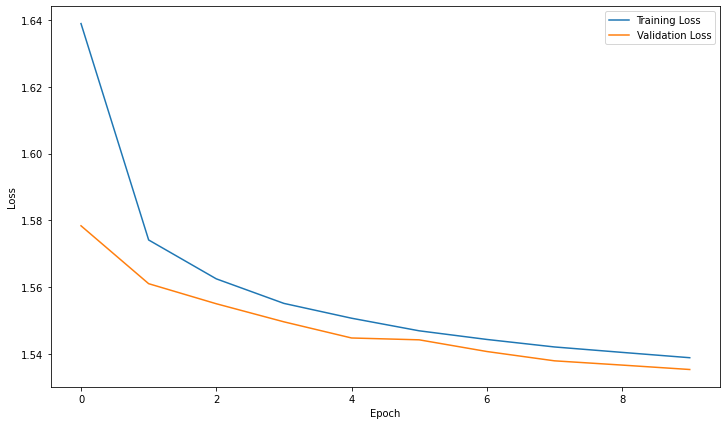

In [25]:
plt.figure(figsize=(12,7))
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()